# CenterNet


In [1]:
import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from ROI.centernet import CenterNet
from ROI.dataset import RoiDataset
from ROI.helpers import *
from ROI.losses import CenterLoss

In [ ]:
ORIGA_DIR = '../data/ORIGA'
CSV_FILE = ORIGA_DIR + '/origa.csv'

generate_bbox_csv(
    image_dir=ORIGA_DIR + '/Images_Square',
    mask_dir=ORIGA_DIR + '/Masks_Square',
    csv_file=CSV_FILE,
    margin=0,
)

In [21]:
# Hyper-params
MODEL_PATH = r'C:\Users\kappe\PycharmProjects\DP-GlaucomaSegmentation\notebooks\centernet_resnet18.pth'

input_size = 512
IN_SCALE = 512 // input_size
MODEL_SCALE = 4

batch_size = 2
model_name = 'resnet18'

In [33]:
df = pd.read_csv(CSV_FILE)

image_ids = df['image_id'].unique()
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=411)

print('Number of training images:', len(train_ids))
print('Number of validation images:', len(val_ids))

df.head()

Number of training images: 520
Number of validation images: 130


image_id                             mask_id  \
0  ..\data\ORIGA\Images_Square\001.jpg  ..\data\ORIGA\Masks_Square\001.png   
1  ..\data\ORIGA\Images_Square\002.jpg  ..\data\ORIGA\Masks_Square\002.png   
2  ..\data\ORIGA\Images_Square\003.jpg  ..\data\ORIGA\Masks_Square\003.png   
3  ..\data\ORIGA\Images_Square\004.jpg  ..\data\ORIGA\Masks_Square\004.png   
4  ..\data\ORIGA\Images_Square\005.jpg  ..\data\ORIGA\Masks_Square\005.png   

       x      y     w     h  disc_center_x  disc_center_y  cup_center_x  \
0  276.0  215.0  77.0  94.0          314.0          262.0         315.0   
1  179.0  185.0  72.0  91.0          215.0          230.0         215.0   
2  163.0  203.0  80.0  84.0          203.0          245.0         203.0   
3  298.0  218.0  66.0  75.0          331.0          255.0         330.0   
4  154.0  211.0  75.0  79.0          191.0          250.0         193.0   

   cup_center_y  disc_x  disc_y  disc_w  disc_h  cup_x  cup_y  cup_w  cup_h  
0         261.0   276.0   215.0    77.0    94.0  289.0  228.0   52.0   67.0  
1         230.0   179.0   185.0    72.0    91.0  190.0  199.0   51.0   63.0  
2         246.0   163.0   203.0    80.0    84.0  165.0  206.0   77.0   81.0  
3         252.0   298.0   218.0    66.0    75.0  307.0  225.0   47.0   54.0  
4         251.0   154.0   211.0    75.0    79.0  166.0  227.0   55.0   49.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) tensor(-6.0373) tensor(4.2956)
torch.Size([3, 512, 512]) tensor(0.) tensor(1.)


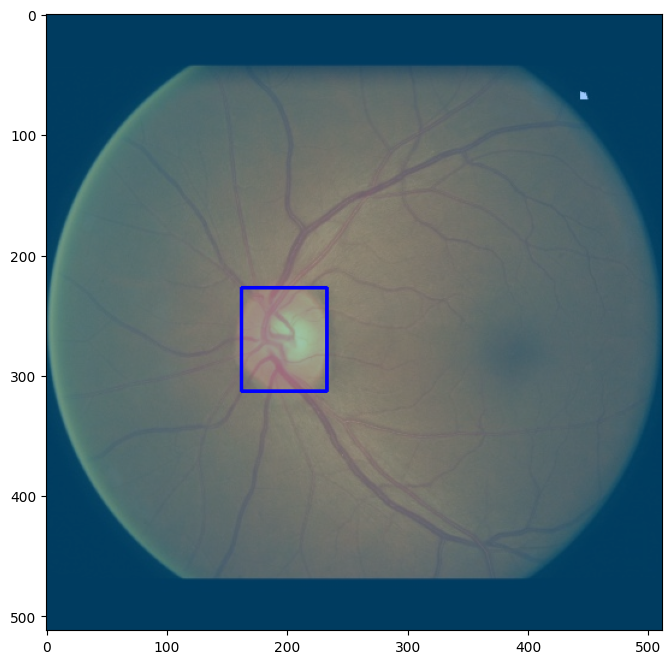

In [34]:
transform = A.Compose([
    A.Resize(input_size, input_size),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.9400, 0.6225, 0.3316), std=(0.1557, 0.1727, 0.1556)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

dataset = RoiDataset(train_ids, df, input_size, IN_SCALE, MODEL_SCALE, transform)
img, heatmap, regression, bboxes = dataset[0]

print(img.shape, img.min(), img.max())
img = (img - img.min()) / (img.max() - img.min())
print(img.shape, img.min(), img.max())

res = img.permute(1, 2, 0).numpy()
for bbox in bboxes:
    x, y, w, h = bbox
    x, y, w, h = int(x), int(y), int(w), int(h)
    res = cv.rectangle(res, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.figure(figsize=(8, 8))
plt.imshow(res)
plt.show()

In [35]:
train_dataset = RoiDataset(train_ids, df, input_size, IN_SCALE, MODEL_SCALE, transform)
val_dataset = RoiDataset(val_ids, df, input_size, IN_SCALE, MODEL_SCALE, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CenterNet()
if MODEL_PATH:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print('Model loaded from', MODEL_PATH)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = CenterLoss()

Model loaded from C:\Users\kappe\PycharmProjects\DP-GlaucomaSegmentation\notebooks\centernet_resnet18.pth


In [ ]:
def train(model, optimizer, criterion, loader):
    model.train()
    history = defaultdict(float)
    total = len(loader)

    pbar = tqdm(loader, total=total, leave=True, desc='Training')
    for batch_idx, (inputs, heatmap_gt, regression_gt, bboxes_gt) in enumerate(pbar, start=1):
        # Move data to device
        inputs = inputs.to(device)
        heatmap_gt = heatmap_gt.to(device)
        regression_gt = regression_gt.to(device)

        # Forward pass
        optimizer.zero_grad()
        heatmap_preds, regression_preds = model(inputs)
        preds = torch.cat((heatmap_preds, regression_preds), dim=1)

        # Compute loss
        loss, mask_loss, regr_loss = criterion(preds, heatmap_gt, regression_gt)

        # Update tracking variables in history
        history['loss'] += loss.item()
        history['mask'] += mask_loss.item()
        history['regr'] += regr_loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

        # Show stats in progress bar
        pbar.set_description('Training: ' + ', '.join([f'{v / batch_idx:.3f}' for k, v in history.items()]))

    # Return mean metrics and losses
    return {k: v / total for k, v in history.items()}


def validate(model, criterion, loader):
    model.eval()
    history = defaultdict(float)
    total = len(loader)

    pbar = tqdm(loader, total=total, leave=True, desc='Validation')
    for batch_idx, (inputs, heatmap_gt, regression_gt, bboxes_gt) in enumerate(pbar, start=1):
        # Move data to device
        inputs = inputs.to(device)
        heatmap_gt = heatmap_gt.to(device)
        regression_gt = regression_gt.to(device)

        # Forward pass
        heatmap_preds, regression_preds = model(inputs)
        preds = torch.cat((heatmap_preds, regression_preds), dim=1)

        # Compute loss
        loss, mask_loss, regr_loss = criterion(preds, heatmap_gt, regression_gt)

        # Update tracking variables in history
        history['loss'] += loss.item()
        history['mask'] += mask_loss.item()
        history['regr'] += regr_loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

        # Show stats in progress bar
        pbar.set_description('Validation: ' + ', '.join([f'{v / batch_idx:.3f}' for k, v in history.items()]))

    # Return mean metrics and losses
    return {k: v / total for k, v in history.items()}


epochs = 3
logs = []
logs_eval = []

for epoch in range(epochs):
    print(f'Epochs {epoch + 1}/{epochs} ')

    train_results = train(model, optimizer, criterion, train_loader)
    val_results = validate(model, criterion, val_loader)

    # save logs
    log_epoch = {
        'epoch': epoch + 1,
        'lr': optimizer.state_dict()['param_groups'][0]['lr'],
        'train_loss': train_results['loss'],
        'train_mask': train_results['mask'],
        'train_regr': train_results['regr'],
        'valid_loss': val_results['loss'],
        'valid_mask': val_results['mask'],
        'valid_regr': val_results['regr'],
    }
    logs.append(log_epoch)

In [ ]:
train_loss = [log['train_loss'] for log in logs]
train_mask_loss = [log['train_mask'] for log in logs]
train_regr_loss = [log['train_regr'] for log in logs]

val_loss = [log['valid_loss'] for log in logs]
val_mask_loss = [log['valid_mask'] for log in logs]
val_regr_loss = [log['valid_regr'] for log in logs]

plt.figure(figsize=(8, 8))
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

# Show predictions

Number of boxes: 2 Scores: [0.7436047 0.7959331]


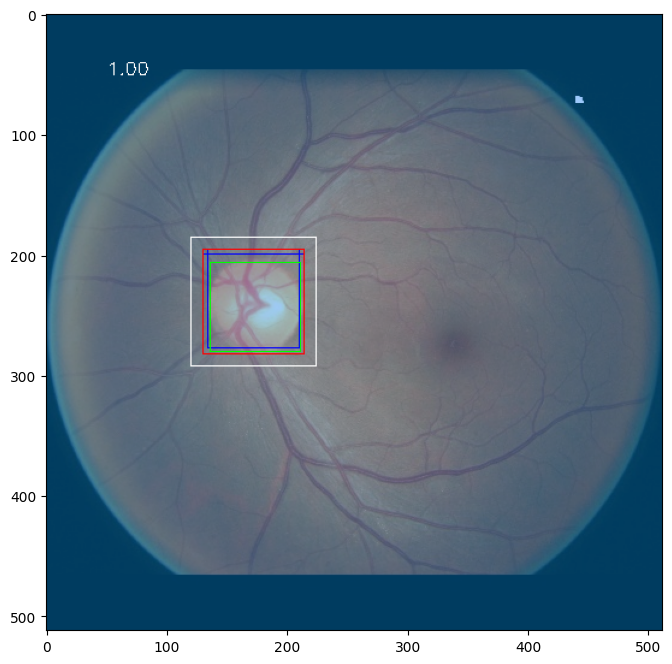

Number of boxes: 1 Scores: [0.6073116]


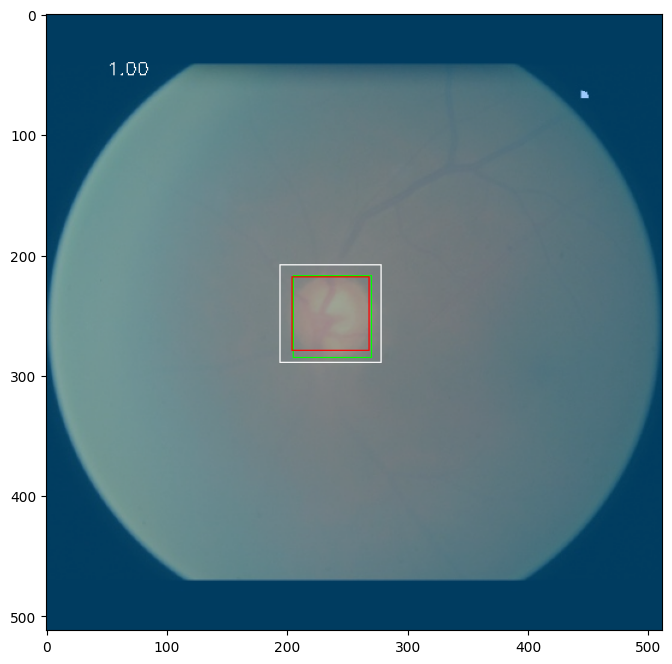

Number of boxes: 2 Scores: [0.7281221 0.784836 ]


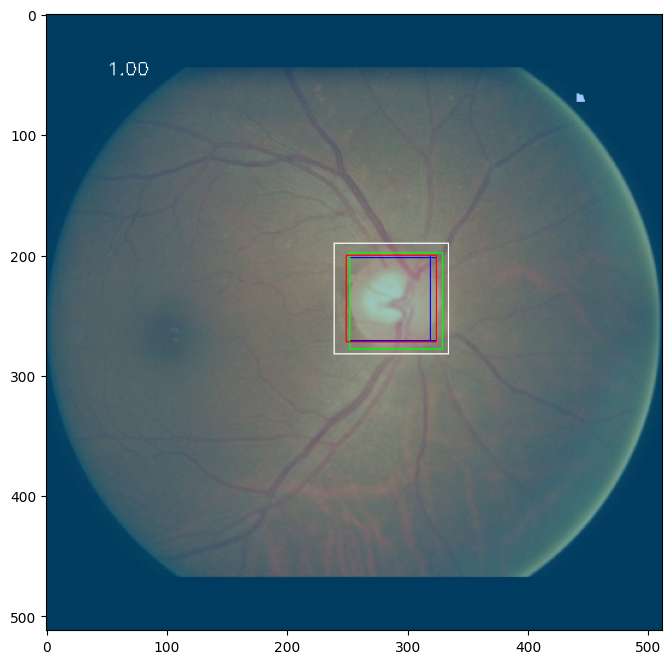

Number of boxes: 1 Scores: [0.679203]


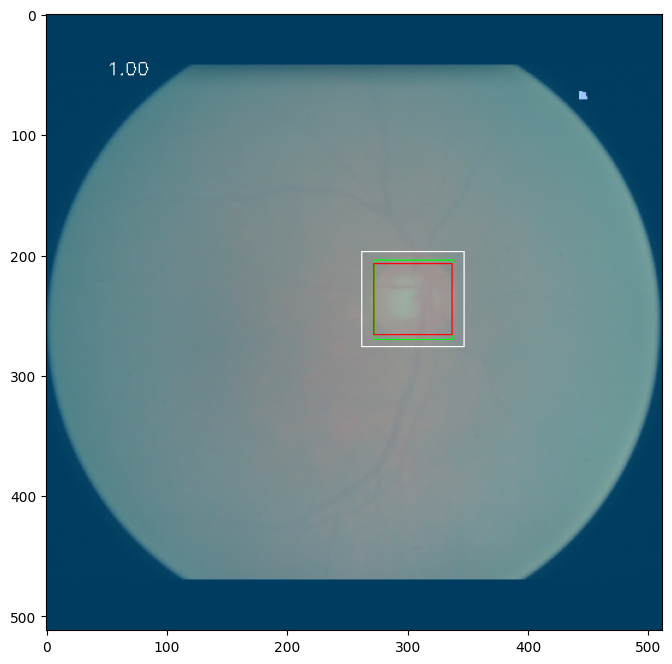

Number of boxes: 2 Scores: [0.687384  0.7730811]


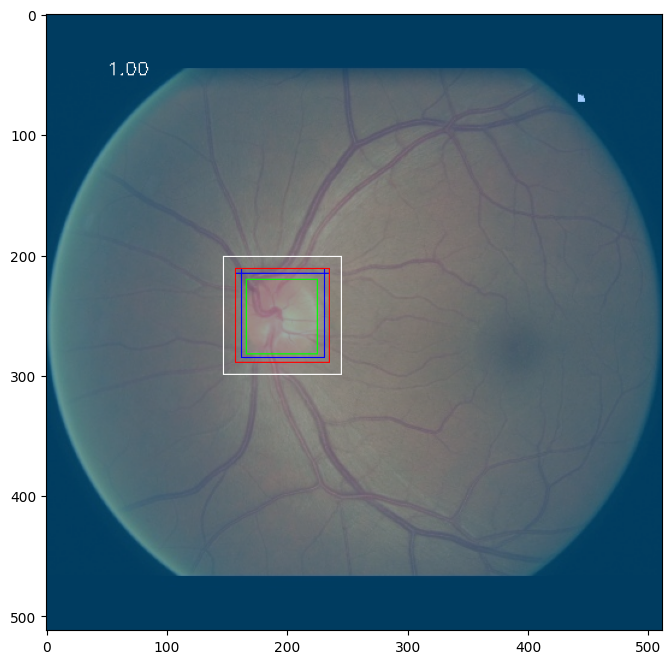

Number of boxes: 2 Scores: [0.63866675 0.61707366]


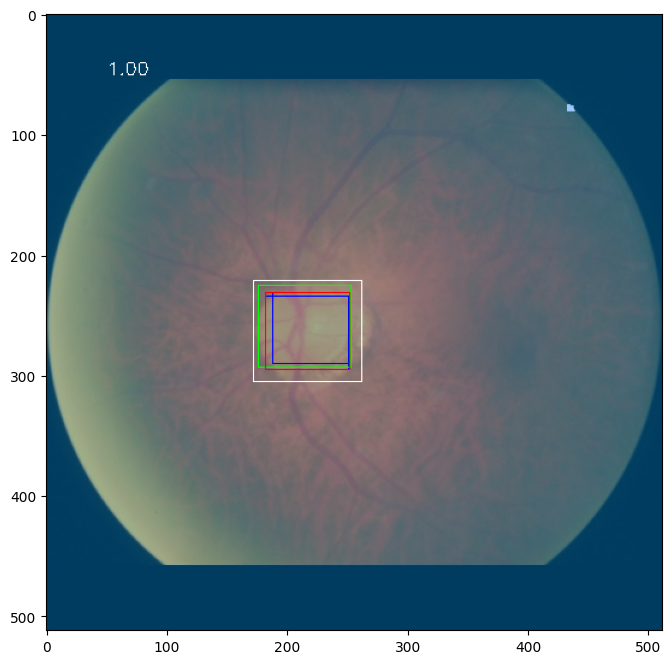

Number of boxes: 4 Scores: [0.65822977 0.6432698  0.73192793 0.7353263 ]


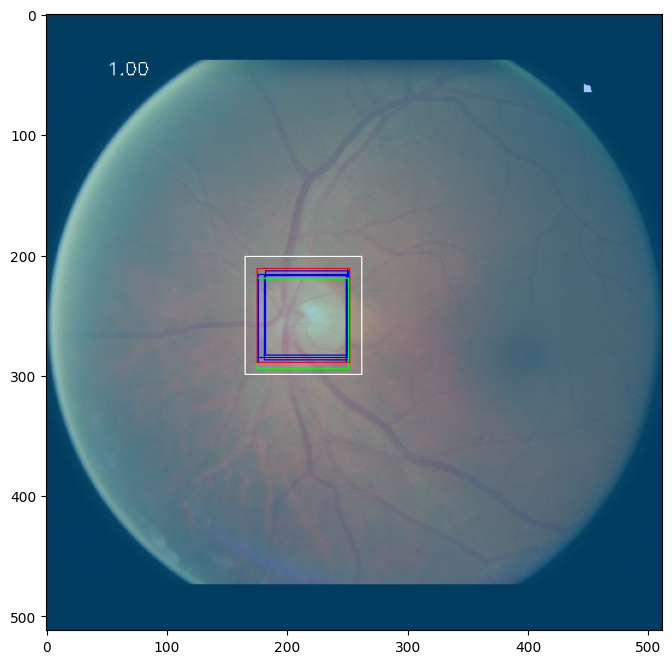

Number of boxes: 2 Scores: [0.70122373 0.69834614]


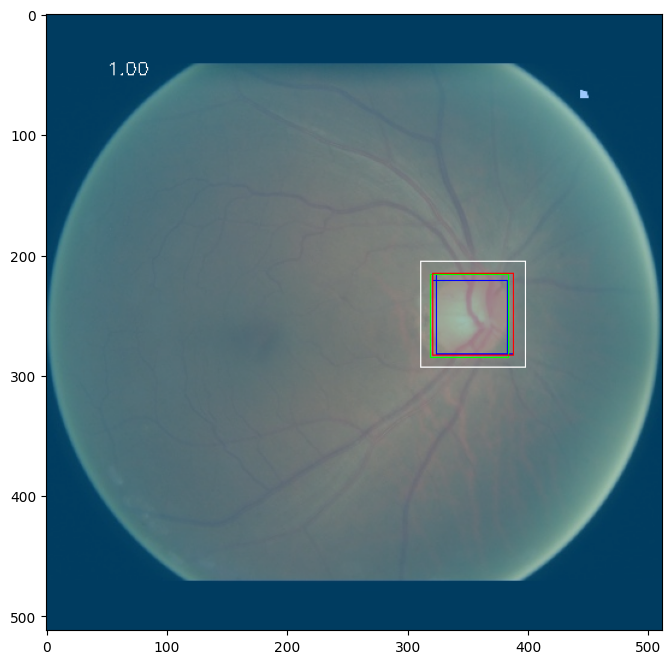

No boxes found for image 4
Number of boxes: 2 Scores: [0.71376044 0.79070634]


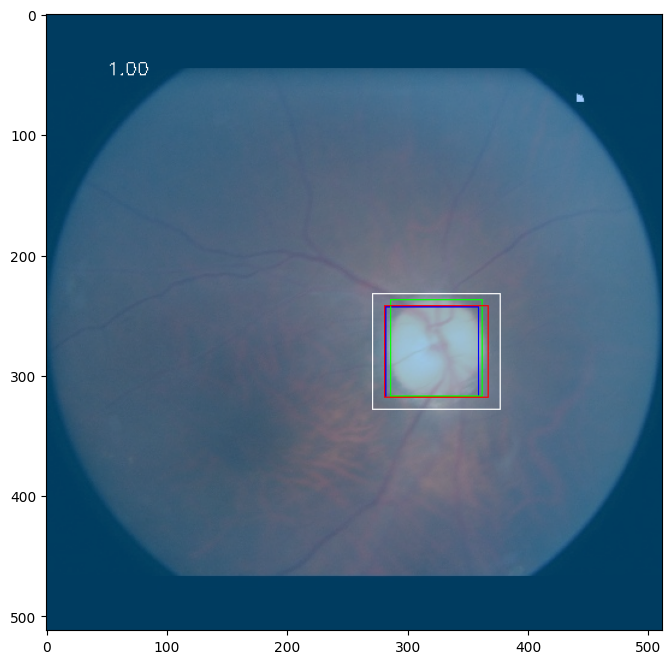

Number of boxes: 2 Scores: [0.6207884  0.75230265]


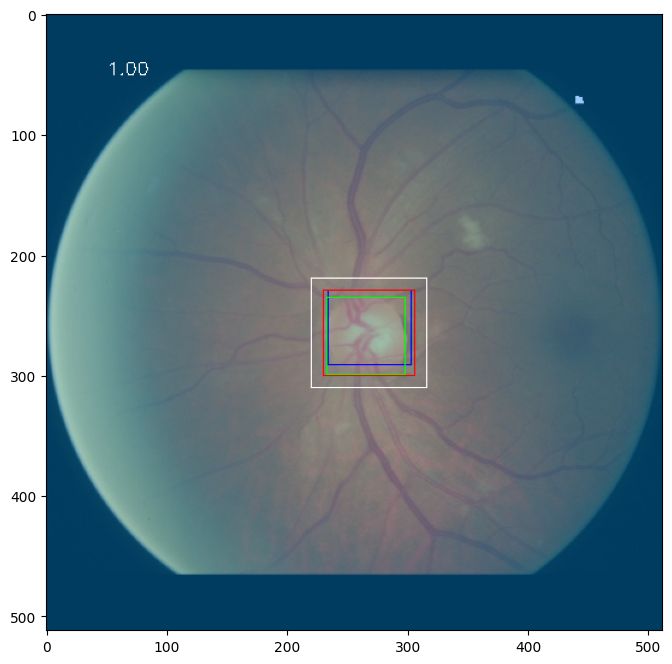

Number of boxes: 2 Scores: [0.6710363 0.6863441]


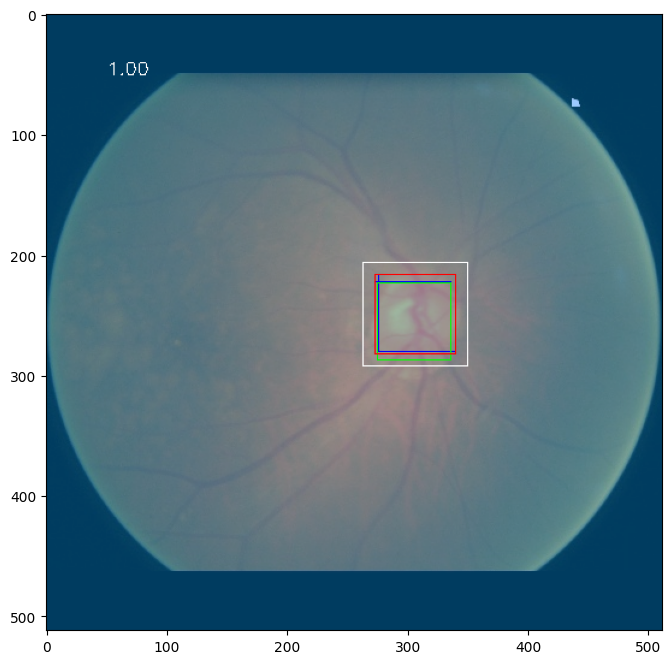

In [53]:
margin = 10

for i, (imgs, heatmap_gt, regression_gt, boxes_gt) in enumerate(val_loader):
    if i > 5:
        break

    imgs = imgs.to(device)
    with torch.no_grad():
        heatmap, regression = model(imgs)

    for img, hm, regr, box_gt in zip(imgs, heatmap, regression, boxes_gt):

        # img = img[0]
        # heatmap = heatmap[0, 0]
        # regression = regression[0].cpu().numpy()
        # bboxes_gt = bboxes_gt[0].cpu().numpy()
        img = img.permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        img = (img * 255).astype(np.uint8)
        hm = hm.squeeze()
        regr = regr.cpu().numpy()
        box_gt = box_gt.cpu().numpy()
    
        hm = torch.sigmoid(hm).cpu().numpy()
        hm = pool_duplicates(hm)
        bboxes, scores = prediction_to_bboxes(hm, regr, input_size, MODEL_SCALE, 0.6)
        if len(bboxes) == 0:
            print('No boxes found for image', i)
            continue
        merged_box = merge_overlapping_boxes(bboxes, scores, 0.5)
        print('Number of boxes:', len(bboxes), 'Scores:', scores)
    
        for box, score in zip(bboxes, scores):
            x, y, w, h = box
            x, y, w, h = int(x), int(y), int(w), int(h)
            img = cv.rectangle(img.copy(), (x, y), (x + w, y + h), (0, 0, 255), 1)
    
        for bbox in box_gt:
            x, y, w, h = bbox
            x, y, w, h = int(x), int(y), int(w), int(h)
            img = cv.rectangle(img.copy(), (x, y), (x + w, y + h), (0, 255, 0), 1)
    
        if merged_box is not None:
            x, y, w, h = merged_box
            x, y, w, h = int(x), int(y), int(w), int(h)
            img = cv.rectangle(img.copy(), (x, y), (x + w, y + h), (255, 0, 0), 1)
    
            # Add margin to merged box
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(input_size, w + 2 * margin)
            h = min(input_size, h + 2 * margin)
            img = cv.rectangle(img.copy(), (x, y), (x + w, y + h), (255, 255, 255), 1)
            cov = calculate_coverage(box_gt[0], [x, y, w, h])
            img = cv.putText(img.copy(), f'{cov:.2f}', (50, 50), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        plt.imshow(img)
        plt.show()